In [1]:
] activate .

In [2]:
# ] add https://github.com/RalphAS/JacobiSVD.jl

In [40]:
using GenericSVD, JacobiSVD, LinearAlgebra, Plots;

pyplot();
PyPlot.plt.style.use("publication_tex")
default(
    framestyle = :box,
    legend = true,
    grid = false,
    size = (1.5*250, 250),
    linewidth = 1
);

In [274]:
"""

calc_product_chain(B,N) -> (R, svs)

Calculate B^N as B*B*B*B*...*B from right to left.

Returns the result `R` and the singular values (column of `svs`) of all intermediate powers (rows of `svs`).
"""
function calc_product_chain(B, N)
    bs = size(B,1)
    R = Matrix{eltype(B)}(I, bs, bs)
    svs = zeros(eltype(B), N,bs)
    svc = 1
    for k in 1:N
        R = B * R
        svs[svc,:] = log.(svdvals(R))
        svc += 1
    end
    return (R, svs)
end


"""
Does the same as `calc_product_chain` but stabilizes the
matrix products by performing them in UDT (QR) or UDVt (SVD) form.
This way different scales are kept separate as much as possible.
"""
function calc_product_chain_stabilized(B, N, decomposition_method)
    svs = zeros(eltype(B), N,size(B,1))
    U, D, X = decomposition_method(B)
    svs[1,:] = log.(D)
    svc = 2

    for k in 2:N
        # multiply B from the left to UDX
        # and update UDX
        U = B * U
        U *= Diagonal(D)
        U, D, Xnew = decomposition_method(U)
        X = Xnew * X
        
        # keep singular values
        svs[svc,:] = log.(D)
        svc += 1
    end
    
    return (U * Diagonal(D) * X, svs)
end

calc_product_chain_stabilized

In [275]:
# Define a couple of decomposition methods which must output UDX
gesdd = x -> LinearAlgebra.LAPACK.gesdd!('A', copy(x))
gesvd = x -> LinearAlgebra.LAPACK.gesvd!('A', 'A', copy(x))

genericsvd = x -> (F = svd(x); return (F.U, F.S, F.Vt))

gesvj = x -> JacobiSVD.gesvj!('G','U','V', copy(x))

function qr_udt(A::AbstractMatrix{C}) where C<:Number
  F = qr(A, Val(true))
  p = F.p
  @views p[p] = collect(1:length(p))
  D = abs.(real(diag(F.R)))
  T = (Diagonal(1 ./ D) * F.R)[:, p]
  return Matrix(F.Q), D, T
end

qr_udt (generic function with 1 method)

In [6]:
# Some basic tests
B = rand(5,5) # regular matrix
N = 10
@assert isapprox(calc_product_chain(B, N)[1], B^N)
@assert isapprox(calc_product_chain_stabilized(B, N, gesdd)[1], B^N)
@assert isapprox(calc_product_chain_stabilized(B, N, gesvd)[1], B^N)
@assert isapprox(calc_product_chain_stabilized(B, N, genericsvd)[1], B^N)
@assert isapprox(calc_product_chain_stabilized(B, N, qr_udt)[1], B^N)
# @assert isapprox(calc_product_chain_stabilized(B, N, gesvj)[1], B^N)

# B from spin-fermion model

In [276]:
B = [0.975173 0.0971936 0.192475 0.0191836 0.0 0.0 0.0 0.0; 0.0971936 0.975173 0.0191836 0.192475 0.0 0.0 0.0 0.0; 0.192475 0.0191836 0.975173 0.0971936 0.0 0.0 0.0 0.0; 0.0191836 0.192475 0.0971936 0.975173 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.975173 -0.192475 -0.0971936 0.0191836; 0.0 0.0 0.0 0.0 -0.192475 0.975173 0.0191836 -0.0971936; 0.0 0.0 0.0 0.0 -0.0971936 0.0191836 0.975173 -0.192475; 0.0 0.0 0.0 0.0 0.0191836 -0.0971936 -0.192475 0.975173]

8×8 Array{Float64,2}:
 0.975173   0.0971936  0.192475   …   0.0         0.0         0.0      
 0.0971936  0.975173   0.0191836      0.0         0.0         0.0      
 0.192475   0.0191836  0.975173       0.0         0.0         0.0      
 0.0191836  0.192475   0.0971936      0.0         0.0         0.0      
 0.0        0.0        0.0           -0.192475   -0.0971936   0.0191836
 0.0        0.0        0.0        …   0.975173    0.0191836  -0.0971936
 0.0        0.0        0.0            0.0191836   0.975173   -0.192475 
 0.0        0.0        0.0           -0.0971936  -0.192475    0.975173 

In [277]:
Bbig = BigFloat.(B)
N = 400

setprecision(100) do
    global svs_genericsvd = calc_product_chain_stabilized(Bbig, N, genericsvd)[2];
end
svs_qr_udt = calc_product_chain_stabilized(B, N, qr_udt)[2];
svs_gesvd = calc_product_chain_stabilized(B, N, gesvd)[2];
svs_gesdd = calc_product_chain_stabilized(B, N, gesdd)[2];
svs_gesvj = calc_product_chain_stabilized(B, N, gesvj)[2];

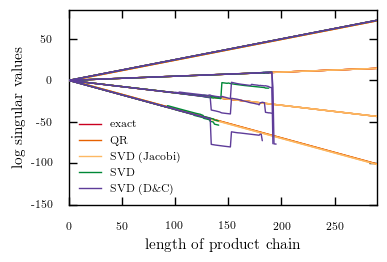

In [278]:
plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot!(svs_qr_udt, color="#E66101", labels = reshape(["QR", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesvj, color="#FDB863", labels = reshape(["SVD (Jacobi)", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesvd, color="#008837", labels = reshape(["SVD", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesdd, color="#5E3C99", labels = reshape(["SVD (D\\&C)", "", "","", "","", "", ""], (1,8)))

ylabel!("log singular values")
xlabel!("length of product chain")
ylims!(-150, 85)
xlims!((0., 290.))
savefig("decomp_comparison.pdf")

# Simple interacting system

In [283]:
n = 8
T = diagm(-1 => fill(1, n-1), 1 => fill(1, n-1))

8×8 Array{Int64,2}:
 0  1  0  0  0  0  0  0
 1  0  1  0  0  0  0  0
 0  1  0  1  0  0  0  0
 0  0  1  0  1  0  0  0
 0  0  0  1  0  1  0  0
 0  0  0  0  1  0  1  0
 0  0  0  0  0  1  0  1
 0  0  0  0  0  0  1  0

In [284]:
V = diagm(0 => fill(-0.1, n))

8×8 Array{Float64,2}:
 -0.1   0.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -0.1   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -0.1   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -0.1   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0  -0.1   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0  -0.1   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  -0.1   0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0  -0.1

In [285]:
B = exp(-0.1/2 .* T) * exp(-0.1 .* V) * exp(-0.1/2 .* T)

8×8 Array{Float64,2}:
  1.01511      -0.101342      0.00506289   …   1.4046e-9    -2.006e-11  
 -0.101342      1.02017      -0.101511        -8.43112e-8    1.4046e-9  
  0.00506289   -0.101511      1.02018          4.21697e-6   -8.42912e-8 
 -0.000168679   0.0050671    -0.101511        -0.000168763   4.21556e-6 
  4.21556e-6   -0.000168763   0.00506711       0.0050671    -0.000168679
 -8.42912e-8    4.21697e-6   -0.000168763  …  -0.101511      0.00506289 
  1.4046e-9    -8.43112e-8    4.21697e-6       1.02017      -0.101342   
 -2.006e-11     1.4046e-9    -8.42912e-8      -0.101342      1.01511    

In [286]:
Bbig = BigFloat.(B)
N = 500

setprecision(100) do
    global svs_genericsvd = calc_product_chain_stabilized(Bbig, N, genericsvd)[2];
end
svs_qr_udt = calc_product_chain_stabilized(B, N, qr_udt)[2];
svs_gesvd = calc_product_chain_stabilized(B, N, gesvd)[2];
svs_gesdd = calc_product_chain_stabilized(B, N, gesdd)[2];
svs_gesvj = calc_product_chain_stabilized(B, N, gesvj)[2];

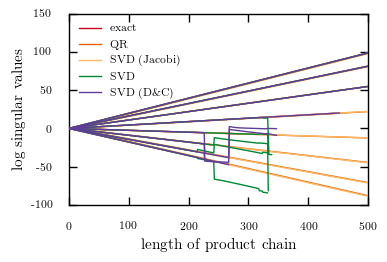

In [287]:
plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot!(svs_qr_udt, color="#E66101", labels = reshape(["QR", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesvj, color="#FDB863", labels = reshape(["SVD (Jacobi)", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesvd, color="#008837", labels = reshape(["SVD", "", "","", "","", "", ""], (1,8)))
plot!(svs_gesdd, color="#5E3C99", labels = reshape(["SVD (D\\&C)", "", "","", "","", "", ""], (1,8)))

ylabel!("log singular values")
xlabel!("length of product chain")
ylims!(-100, 150)
xlims!((0., 500.))
savefig("decomp_comparison_simple.pdf")

## Stabilization - principle issue

In [288]:
svs_naive = calc_product_chain(B, N)[2]

500×8 Array{Float64,2}:
  0.197939   0.163209   0.11     0.0447296  …  -0.09    -0.143209  -0.177939
  0.395877   0.326418   0.22     0.0894593     -0.18    -0.286418  -0.355877
  0.593816   0.489627   0.33     0.134189      -0.27    -0.429627  -0.533816
  0.791754   0.652836   0.44     0.178919      -0.36    -0.572836  -0.711754
  0.989693   0.816044   0.55     0.223648      -0.45    -0.716044  -0.889693
  1.18763    0.979253   0.66     0.268378   …  -0.54    -0.859253  -1.06763 
  1.38557    1.14246    0.77     0.313107      -0.63    -1.00246   -1.24557 
  1.58351    1.30567    0.88     0.357837      -0.72    -1.14567   -1.42351 
  1.78145    1.46888    0.99     0.402567      -0.81    -1.28888   -1.60145 
  1.97939    1.63209    1.1      0.447296      -0.9     -1.43209   -1.77939 
  2.17732    1.7953     1.21     0.492026   …  -0.99    -1.5753    -1.95732 
  2.37526    1.95851    1.32     0.536756      -1.08    -1.71851   -2.13526 
  2.5732     2.12172    1.43     0.581485      -1.17

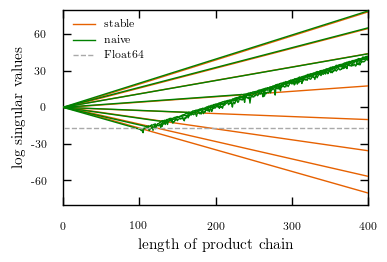

In [289]:
# plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot(svs_qr_udt, color="#E66101", labels = reshape(["stable", "", "","", "","", "", ""], (1,8)))
plot!(svs_naive, color=:green, labels = reshape(["naive", "", "","", "","", "", ""], (1,8)))
plot!(1:400, fill(-17, 400), color=:darkgray, linestyle=:dash, label = "Float64")

ylabel!("log singular values")
xlabel!("length of product chain")
ylims!(-80, 80)
xlims!((0., 400.))
savefig("naive_vs_stable.pdf")

In [290]:
using DoubleFloats
Bdb64 = Double64.(B)
svs_naive = calc_product_chain(Bdb64, N)[2]

500×8 Array{DoubleFloat{Float64},2}:
  0.197938524157182    0.16320888862379598  …    -0.1779385241571815
  0.395877048314364    0.32641777724759197       -0.355877048314363 
  0.593815572471546    0.4896266658713879        -0.5338155724715445
  0.791754096628728    0.6528355544951839        -0.711754096628726 
  0.98969262078591     0.8160444431189798        -0.8896926207859076
  1.187631144943092    0.9792533317427758   …    -1.067631144943089 
  1.3855696691002741   1.1424622203665717        -1.2455696691002707
  1.583508193257456    1.3056711089903679        -1.423508193257452 
  1.781446717414638    1.4688799976141638        -1.6014467174146336
  1.97938524157182     1.6320888862379597        -1.7793852415718152
  2.177323765729002    1.7952977748617558   …    -1.9573237657289968
  2.375262289886184    1.9585066634855517        -2.135262289886178 
  2.573200814043366    2.1217155521093476        -2.3132008140433595
  ⋮                                         ⋱                     

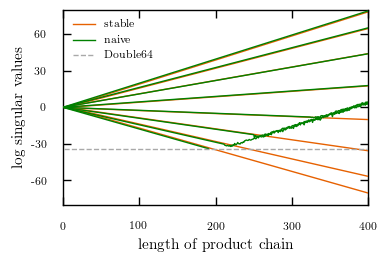

In [291]:
# plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot(svs_qr_udt, color="#E66101", labels = reshape(["stable", "", "","", "","", "", ""], (1,8)))
plot!(svs_naive, color=:green, labels = reshape(["naive", "", "","", "","", "", ""], (1,8)))
plot!(1:400, fill(-34, 400), color=:darkgray, linestyle=:dash, label = "Double64")

ylabel!("log singular values")
xlabel!("length of product chain")
ylims!(-80, 80)
xlims!((0., 400.))
savefig("naive_vs_stable_db64.pdf")